# Compare embedding method

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'


# === Load embeddings ===
def load_embedding(path):
    data = torch.load(path)
    X = data['X']
    if X.ndim == 3 and X.shape[1] == 1:
        X = X.squeeze(1)
    X = X.numpy()
    y = data['y'].numpy()
    return X, y

X_delta, y_delta = load_embedding("data/esm2_delta_embeddings.pt")
X_mut, y_mut = load_embedding("data/esm2_embeddings.pt")

# === Classifiers ===
classifiers = {
    "SVM": SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3),
    "MLP": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42),
    "XGBoost": XGBClassifier(
        tree_method="hist",    
        device="cuda",          
        n_estimators=100,
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        device="gpu",                 # Enable GPU
        boosting_type="gbdt",
        random_state=42,
        verbosity=-1
    )
}

# === Cross Validation ===
def evaluate_model(X, y, name=""):
    print(f"\n🔍 Evaluating on {name} embeddings")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = {}
    for clf_name, clf in classifiers.items():
        accs, f1s = [], []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accs.append(accuracy_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred, average="macro"))
        
        results[clf_name] = {
            "Accuracy": np.mean(accs),
            "MacroF1": np.mean(f1s)
        }
        print(f"  {clf_name}: Accuracy = {results[clf_name]['Accuracy']:.4f}, MacroF1 = {results[clf_name]['MacroF1']:.4f}")
    
    df = pd.DataFrame(results).T
    display(df)
    return df

# Run for both embeddings
delta_result = evaluate_model(X_delta, y_delta, name="ESM2-delta")
mut_result = evaluate_model(X_mut, y_mut, name="ESM2-mutated-only")


🔍 Evaluating on ESM2-delta embeddings
  SVM: Accuracy = 0.6576, MacroF1 = 0.2985
  MLP: Accuracy = 0.8133, MacroF1 = 0.7116
  XGBoost: Accuracy = 0.8533, MacroF1 = 0.7571


/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  LightGBM: Accuracy = 0.7789, MacroF1 = 0.5923


/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,MacroF1
SVM,0.657614,0.298515
MLP,0.813346,0.711579
XGBoost,0.853260,0.757104
LightGBM,0.778870,0.592319



🔍 Evaluating on ESM2-mutated-only embeddings
  SVM: Accuracy = 0.6388, MacroF1 = 0.3469
  MLP: Accuracy = 0.7203, MacroF1 = 0.5623
  XGBoost: Accuracy = 0.7353, MacroF1 = 0.5458


/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  LightGBM: Accuracy = 0.7185, MacroF1 = 0.4546


/home/sunyvxuan/anaconda3/envs/MLMA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,MacroF1
SVM,0.638847,0.346896
MLP,0.720294,0.562298
XGBoost,0.735271,0.545824
LightGBM,0.718542,0.454568


# DNN based model

## Only Protein

Epoch  1 | Loss: 1.3958 | Val Acc: 0.3611
Epoch  2 | Loss: 1.3657 | Val Acc: 0.1268
Epoch  3 | Loss: 1.3180 | Val Acc: 0.3265
Epoch  4 | Loss: 1.2464 | Val Acc: 0.5821
Epoch  5 | Loss: 1.1663 | Val Acc: 0.2367
Epoch  6 | Loss: 1.0980 | Val Acc: 0.6095
Epoch  7 | Loss: 1.0187 | Val Acc: 0.3824
Epoch  8 | Loss: 0.9547 | Val Acc: 0.5189
Epoch  9 | Loss: 0.8989 | Val Acc: 0.5200
Epoch 10 | Loss: 0.8611 | Val Acc: 0.4564
Epoch 11 | Loss: 0.8168 | Val Acc: 0.5409
Epoch 12 | Loss: 0.7818 | Val Acc: 0.6264
Epoch 13 | Loss: 0.7451 | Val Acc: 0.4327
Epoch 14 | Loss: 0.7188 | Val Acc: 0.5050
Epoch 15 | Loss: 0.6815 | Val Acc: 0.4748
Epoch 16 | Loss: 0.6625 | Val Acc: 0.5189
Epoch 17 | Loss: 0.6328 | Val Acc: 0.6364
Epoch 18 | Loss: 0.6138 | Val Acc: 0.6274
Epoch 19 | Loss: 0.5895 | Val Acc: 0.6158
Epoch 20 | Loss: 0.5751 | Val Acc: 0.5911
Epoch 21 | Loss: 0.5574 | Val Acc: 0.6377
Epoch 22 | Loss: 0.5291 | Val Acc: 0.6115
Epoch 23 | Loss: 0.5219 | Val Acc: 0.6640
Epoch 24 | Loss: 0.4994 | Val Acc:

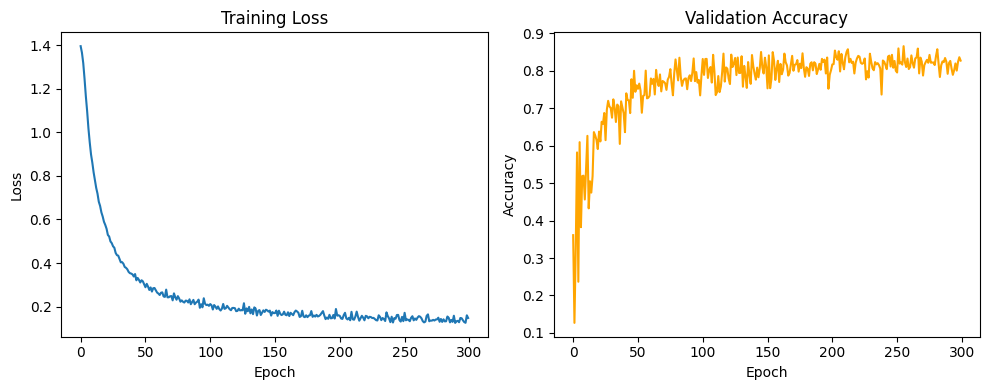


📊 Final Classification Report:
              precision    recall  f1-score   support

     Stage 0       0.72      0.71      0.72       642
     Stage 1       0.64      0.79      0.71      1436
     Stage 2       0.91      0.86      0.88      5115
     Stage 3       0.85      0.69      0.76       459

    accuracy                           0.83      7652
   macro avg       0.78      0.77      0.77      7652
weighted avg       0.84      0.83      0.83      7652



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 300
LR = 1e-4
NUM_CLASSES = 4

# === Load Data ===
data = torch.load("data/esm2_delta_embeddings.pt")
X = data['X']
if X.ndim == 3 and X.shape[1] == 1:
    X = X.squeeze(1)
y = data['y']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Reshape to [B, T, D]
T = 4
D = X.shape[1] // T
X_train = X_train.reshape(-1, T, D)
X_val = X_val.reshape(-1, T, D)

# === DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# === Class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# === Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, dim, heads=4, ff_dim=256, num_classes=4, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.classifier(x)

model = TransformerClassifier(dim=D, num_classes=NUM_CLASSES).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# === Train loop
train_losses, val_accuracies = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = loss_fn(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # === Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(yb)
    acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(acc)
    print(f"Epoch {epoch:2d} | Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.4f}")

# === Plot loss & accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Acc", color="orange")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# === Final Evaluation
print("\n📊 Final Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[f"Stage {i}" for i in range(NUM_CLASSES)]))

[Tokens=2] Epoch 20 | Loss: 0.4485 | Val Acc: 0.6545
[Tokens=2] Epoch 40 | Loss: 0.2807 | Val Acc: 0.7848
[Tokens=2] Epoch 60 | Loss: 0.2703 | Val Acc: 0.7910
[Tokens=2] Epoch 80 | Loss: 0.2335 | Val Acc: 0.7795
[Tokens=2] Epoch 100 | Loss: 0.2010 | Val Acc: 0.7547
[Tokens=2] Epoch 120 | Loss: 0.1895 | Val Acc: 0.8177
[Tokens=2] Epoch 140 | Loss: 0.1949 | Val Acc: 0.8312
[Tokens=2] Epoch 160 | Loss: 0.1771 | Val Acc: 0.8271
[Tokens=2] Epoch 180 | Loss: 0.1900 | Val Acc: 0.8255
[Tokens=2] Epoch 200 | Loss: 0.1622 | Val Acc: 0.8180
[Tokens=2] Best Val Accuracy: 0.8627
[Tokens=4] Epoch 20 | Loss: 0.5565 | Val Acc: 0.6367
[Tokens=4] Epoch 40 | Loss: 0.3413 | Val Acc: 0.6482
[Tokens=4] Epoch 60 | Loss: 0.2589 | Val Acc: 0.7629
[Tokens=4] Epoch 80 | Loss: 0.2135 | Val Acc: 0.8130
[Tokens=4] Epoch 100 | Loss: 0.2131 | Val Acc: 0.7995
[Tokens=4] Epoch 120 | Loss: 0.1854 | Val Acc: 0.7816
[Tokens=4] Epoch 140 | Loss: 0.1735 | Val Acc: 0.8102
[Tokens=4] Epoch 160 | Loss: 0.1638 | Val Acc: 0.8129

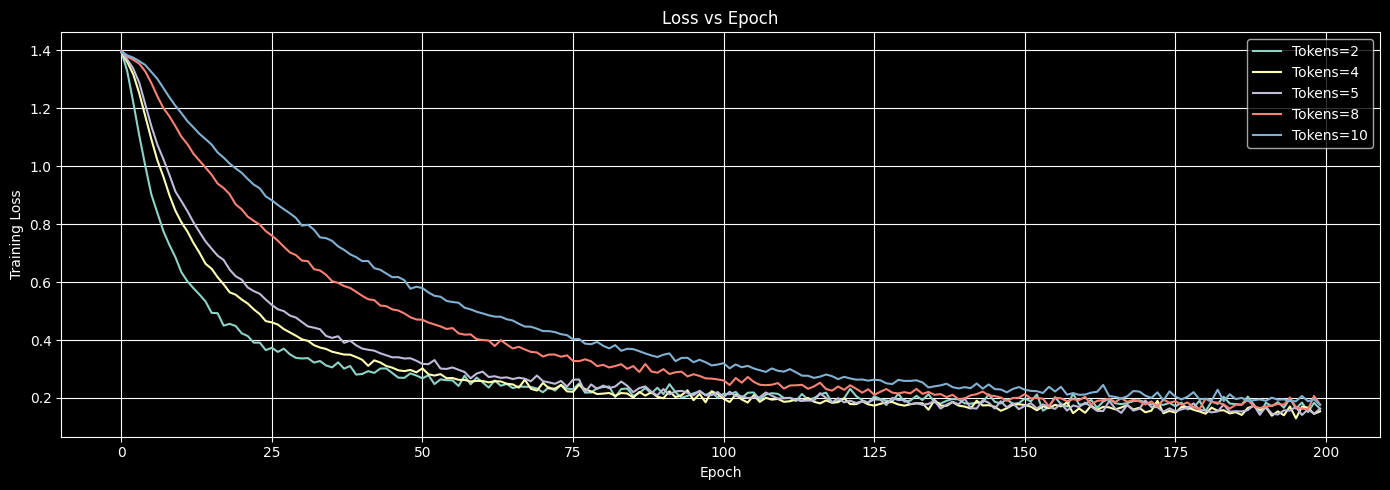

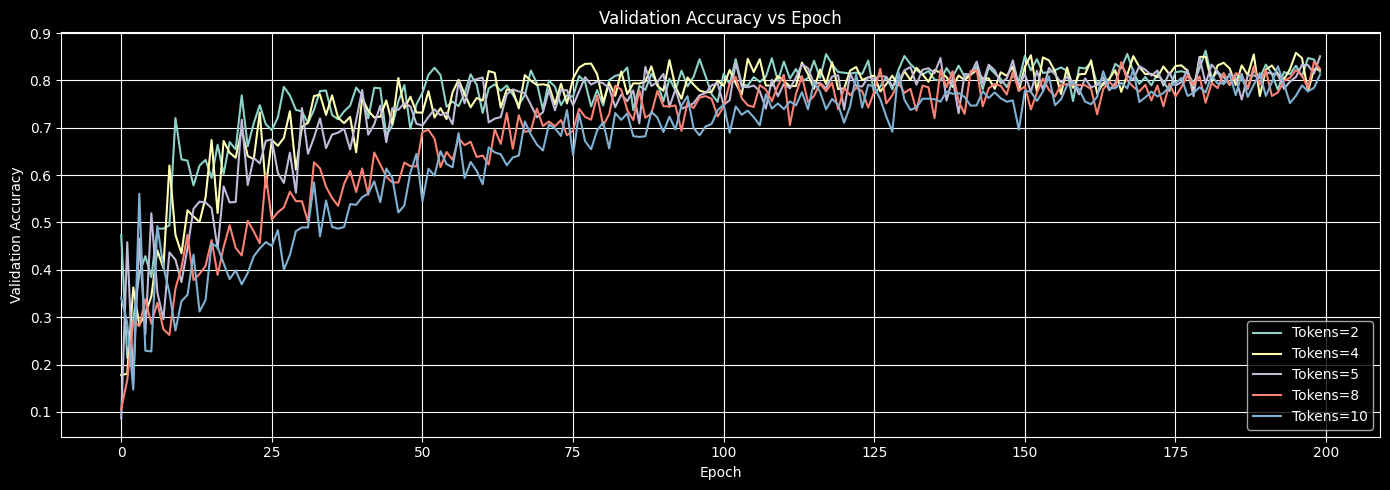

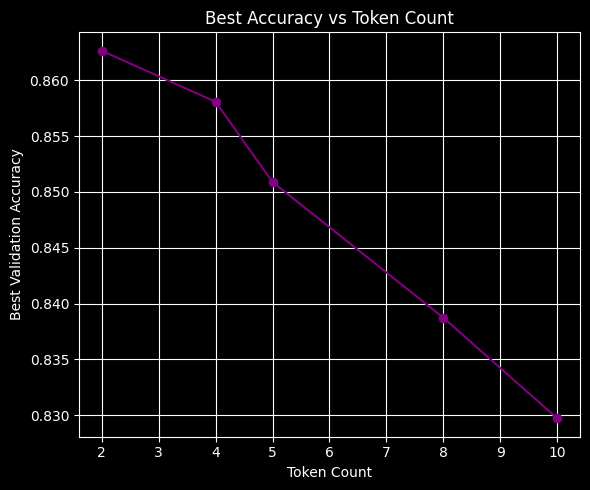

In [1]:
# === Imports ===
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 200
LR = 1e-4
NUM_CLASSES = 4

# === Load Data ===
data = torch.load("data/esm2_delta_embeddings.pt")
X = data['X']
y = data['y']

# Fix shape if needed
if X.ndim == 3 and X.shape[1] == 1:
    X = X.squeeze(1)

# === Tokenization sweep ===
token_options = [2, 4, 5, 8, 10]  # choose values that divide X.shape[1]

results = {}
all_losses = {}
all_accuracies = {}

for T in token_options:
    assert X.shape[1] % T == 0, f"Token count {T} must divide embedding dim {X.shape[1]}"
    D = X.shape[1] // T

    # Reshape
    X_reshaped = X.reshape(-1, T, D)
    X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, stratify=y, random_state=42)

    # Dataset
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Weights
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.numpy()), y=y_train.numpy())
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Model
    class TransformerClassifier(nn.Module):
        def __init__(self, dim, heads=4, ff_dim=256, num_classes=4, dropout=0.1):
            super().__init__()
            encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
            self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
            self.classifier = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, num_classes)
            )

        def forward(self, x):
            x = self.encoder(x)
            x = x.mean(dim=1)
            return self.classifier(x)

    model = TransformerClassifier(dim=D, num_classes=NUM_CLASSES).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    best_acc = 0.0
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_losses.append(total_loss / len(train_loader))

        # === Validation ===
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                preds = model(xb).argmax(dim=1).cpu()
                all_preds.extend(preds)
                all_labels.extend(yb)
        acc = accuracy_score(all_labels, all_preds)
        epoch_accuracies.append(acc)
        best_acc = max(best_acc, acc)
        # print every 10 epochs
        if epoch % 20 == 0 or epoch == EPOCHS:
            print(f"[Tokens={T}] Epoch {epoch:2d} | Loss: {epoch_losses[-1]:.4f} | Val Acc: {acc:.4f}")
            
    results[T] = best_acc
    all_losses[T] = epoch_losses
    all_accuracies[T] = epoch_accuracies
    print(f"[Tokens={T}] Best Val Accuracy: {best_acc:.4f}")

# === Summary Plot ===
print("\n📊 Accuracy by Token Count:")
for k, v in results.items():
    print(f"{k} tokens: {v:.4f}")

# Plot Loss curves
plt.figure(figsize=(14, 5))
for T in token_options:
    plt.plot(all_losses[T], label=f"Tokens={T}")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy curves
plt.figure(figsize=(14, 5))
for T in token_options:
    plt.plot(all_accuracies[T], label=f"Tokens={T}")
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Token Count vs Best Accuracy
plt.figure(figsize=(6, 5))
plt.plot(list(results.keys()), list(results.values()), marker='o', color='purple')
plt.title("Best Accuracy vs Token Count")
plt.xlabel("Token Count")
plt.ylabel("Best Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()



📊 Accuracy by Token Count:
2 tokens: 0.8627
4 tokens: 0.8581
5 tokens: 0.8509
8 tokens: 0.8387
10 tokens: 0.8297


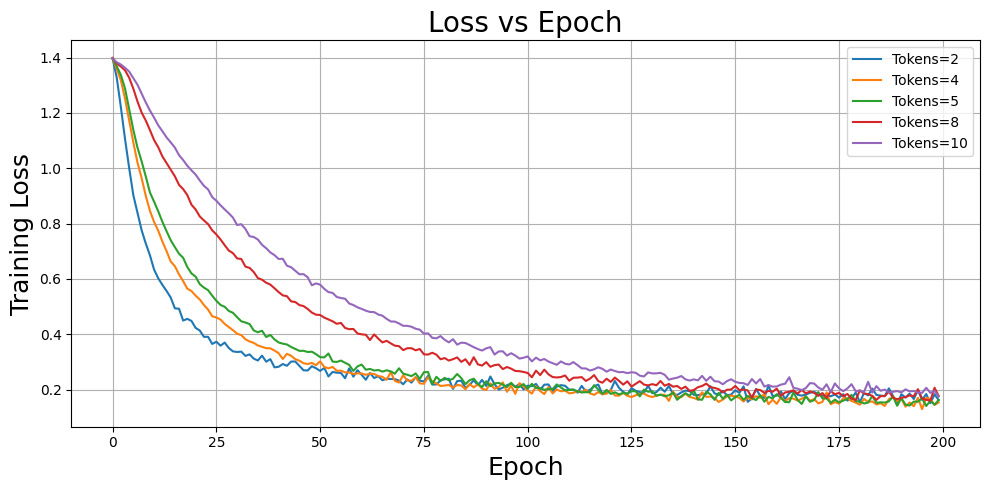

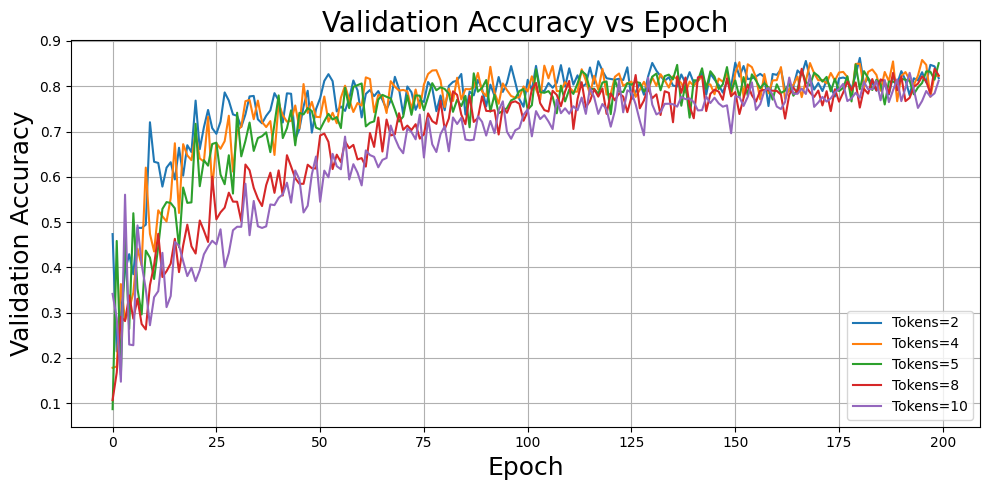

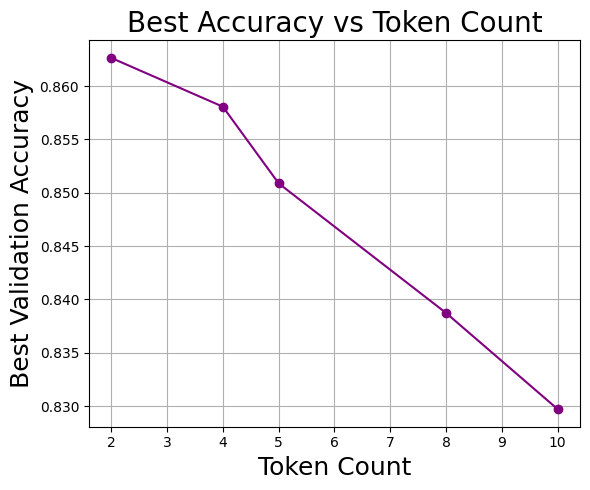

In [4]:
plt.style.use('default')
# === Summary Plot ===
print("\n📊 Accuracy by Token Count:")
for k, v in results.items():
    print(f"{k} tokens: {v:.4f}")

# Plot Loss curves
plt.figure(figsize=(10, 5))
for T in token_options:
    plt.plot(all_losses[T], label=f"Tokens={T}")
plt.title("Loss vs Epoch", fontsize=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Training Loss", fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy curves
plt.figure(figsize=(10, 5))
for T in token_options:
    plt.plot(all_accuracies[T], label=f"Tokens={T}")
plt.title("Validation Accuracy vs Epoch", fontsize=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Validation Accuracy", fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Token Count vs Best Accuracy
plt.figure(figsize=(6, 5))
plt.plot(list(results.keys()), list(results.values()), marker='o', color='purple')
plt.title("Best Accuracy vs Token Count", fontsize=20)
plt.xlabel("Token Count", fontsize=18)
plt.ylabel("Best Validation Accuracy", fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch  1 | Loss: 1.3935 | Val Acc: 0.1790
Epoch  2 | Loss: 1.3728 | Val Acc: 0.1752
Epoch  3 | Loss: 1.3443 | Val Acc: 0.3556
Epoch  4 | Loss: 1.2974 | Val Acc: 0.4046
Epoch  5 | Loss: 1.2486 | Val Acc: 0.3163
Epoch  6 | Loss: 1.1903 | Val Acc: 0.2903
Epoch  7 | Loss: 1.1369 | Val Acc: 0.3257
Epoch  8 | Loss: 1.0774 | Val Acc: 0.4694
Epoch  9 | Loss: 1.0279 | Val Acc: 0.3710
Epoch 10 | Loss: 0.9801 | Val Acc: 0.4799
Epoch 11 | Loss: 0.9403 | Val Acc: 0.4178
Epoch 12 | Loss: 0.8975 | Val Acc: 0.3911
Epoch 13 | Loss: 0.8649 | Val Acc: 0.4698
Epoch 14 | Loss: 0.8319 | Val Acc: 0.4675
Epoch 15 | Loss: 0.8094 | Val Acc: 0.5119
Epoch 16 | Loss: 0.7819 | Val Acc: 0.4850
Epoch 17 | Loss: 0.7618 | Val Acc: 0.5178
Epoch 18 | Loss: 0.7374 | Val Acc: 0.5165
Epoch 19 | Loss: 0.7124 | Val Acc: 0.5289
Epoch 20 | Loss: 0.6896 | Val Acc: 0.4890
Epoch 21 | Loss: 0.6800 | Val Acc: 0.5536
Epoch 22 | Loss: 0.6545 | Val Acc: 0.5263
Epoch 23 | Loss: 0.6473 | Val Acc: 0.5344
Epoch 24 | Loss: 0.6332 | Val Acc:

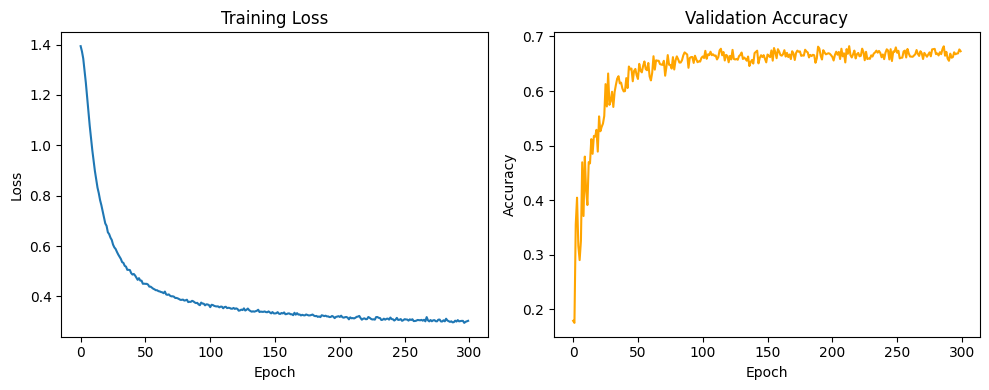


📊 Final Classification Report:
              precision    recall  f1-score   support

     Stage 0       0.42      0.66      0.52       642
     Stage 1       0.50      0.60      0.54      1436
     Stage 2       0.86      0.70      0.77      5115
     Stage 3       0.38      0.63      0.47       459

    accuracy                           0.67      7652
   macro avg       0.54      0.65      0.58      7652
weighted avg       0.73      0.67      0.69      7652



In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 300
LR = 1e-4
NUM_CLASSES = 4

# === Load Data ===
data = torch.load("data/esm2_embeddings.pt")
X = data['X']
if X.ndim == 3 and X.shape[1] == 1:
    X = X.squeeze(1)
y = data['y']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Reshape to [B, T, D]
T = 4
D = X.shape[1] // T
X_train = X_train.reshape(-1, T, D)
X_val = X_val.reshape(-1, T, D)

# === DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# === Class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# === Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, dim, heads=4, ff_dim=256, num_classes=4, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.classifier(x)

model = TransformerClassifier(dim=D, num_classes=NUM_CLASSES).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# === Train loop
train_losses, val_accuracies = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = loss_fn(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # === Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(yb)
    acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(acc)
    print(f"Epoch {epoch:2d} | Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.4f}")

# === Plot loss & accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Acc", color="orange")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# === Final Evaluation
print("\n📊 Final Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[f"Stage {i}" for i in range(NUM_CLASSES)]))

## Clinical

In [17]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

# === Read Data ===
df = pd.read_csv("data/cancer_data_preprocessed.csv")
print("✅ Data loaded. Shape:", df.shape)

# === Select and Encode Features ===
features = ["Cancer Type", "Donor Age at Diagnosis", "Donor Sex", "Histology Abbreviation"]
target = "Cancer Stage"

# Label encode categorical features
cat_features = ["Cancer Type", "Donor Sex", "Histology Abbreviation"]
encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Standardize age
scaler = StandardScaler()
df["Donor Age at Diagnosis"] = scaler.fit_transform(df[["Donor Age at Diagnosis"]])

# Label encode target
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df[target])
NUM_CLASSES = len(label_encoder.classes_)
print(f"🔢 Stage classes: {label_encoder.classes_.tolist()}")

# === Convert to Tensor Format ===
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df["label"].values)

# Reshape to [B, T, D] for transformer
T = 1
D = X.shape[1]
X = X.view(-1, T, D)

# === Train/Val Split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

print(f"📐 Data shape for Transformer: {X.shape}, num_classes={NUM_CLASSES}")

✅ Data loaded. Shape: (38258, 10)
🔢 Stage classes: [1, 2, 3, 4]
📐 Data shape for Transformer: torch.Size([38258, 1, 4]), num_classes=4


Epoch  1 | Loss: 1.3299 | Val Acc: 0.2143
Epoch  2 | Loss: 1.1186 | Val Acc: 0.2938
Epoch  3 | Loss: 1.0501 | Val Acc: 0.2866
Epoch  4 | Loss: 1.0167 | Val Acc: 0.3413
Epoch  5 | Loss: 0.9950 | Val Acc: 0.3755
Epoch  6 | Loss: 0.9791 | Val Acc: 0.3931
Epoch  7 | Loss: 0.9662 | Val Acc: 0.4026
Epoch  8 | Loss: 0.9566 | Val Acc: 0.3972
Epoch  9 | Loss: 0.9469 | Val Acc: 0.4117
Epoch 10 | Loss: 0.9354 | Val Acc: 0.4326
Epoch 11 | Loss: 0.9278 | Val Acc: 0.4315
Epoch 12 | Loss: 0.9184 | Val Acc: 0.4676
Epoch 13 | Loss: 0.9083 | Val Acc: 0.4481
Epoch 14 | Loss: 0.9033 | Val Acc: 0.4676
Epoch 15 | Loss: 0.8971 | Val Acc: 0.4723
Epoch 16 | Loss: 0.8885 | Val Acc: 0.4481
Epoch 17 | Loss: 0.8831 | Val Acc: 0.4750
Epoch 18 | Loss: 0.8757 | Val Acc: 0.4676
Epoch 19 | Loss: 0.8671 | Val Acc: 0.4709
Epoch 20 | Loss: 0.8623 | Val Acc: 0.4718
Epoch 21 | Loss: 0.8522 | Val Acc: 0.4718
Epoch 22 | Loss: 0.8498 | Val Acc: 0.4984
Epoch 23 | Loss: 0.8438 | Val Acc: 0.4941
Epoch 24 | Loss: 0.8368 | Val Acc:

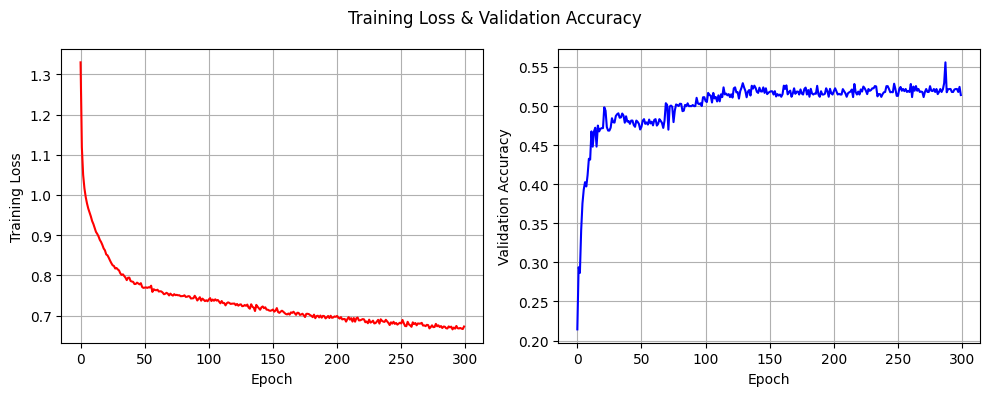

In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "data/cancer_data_preprocessed.csv"
BATCH_SIZE = 64
EPOCHS = 300
LR = 1e-4
NUM_CLASSES = 4

# === Load CSV ===
df = pd.read_csv(DATA_PATH)
df = df[["Cancer Type", "Donor Age at Diagnosis", "Donor Sex", "Histology Abbreviation", "Cancer Stage"]].dropna()

# === Encode categorical features
for col in ["Cancer Type", "Donor Sex", "Histology Abbreviation"]:
    df[col] = LabelEncoder().fit_transform(df[col])

# === Encode labels
df = df[df["Cancer Stage"].isin([1, 2, 3, 4])]
df["label"] = df["Cancer Stage"].astype(int) - 1

# === Prepare X, y
X = df[["Cancer Type", "Donor Age at Diagnosis", "Donor Sex", "Histology Abbreviation"]].values.astype(np.float32)
y = df["label"].values.astype(np.int64)

# === Normalize
X = StandardScaler().fit_transform(X)

# === Reshape for Transformer: (B, T=1, D)
X = torch.tensor(X).unsqueeze(1)
y = torch.tensor(y)

# === Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

# === Weighted CE Loss
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight("balanced", classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# === Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, dim, heads=2, ff_dim=64, num_classes=4, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=ff_dim,
                                                   dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)

model = TransformerClassifier(dim=X.shape[-1], num_classes=NUM_CLASSES).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)

# === Training loop
train_losses, val_accuracies = [], []
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    val_accuracies.append(acc)
    print(f"Epoch {epoch:2d} | Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.4f}")

# === Final Report
print("\n📊 Final Classification Report:")
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = model(xb).argmax(dim=1).cpu()
        y_pred.extend(pred.tolist())
        y_true.extend(yb.tolist())
print(classification_report(y_true, y_pred, target_names=[f"Stage {i}" for i in range(4)]))

# === Plot loss and val acc
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Acc", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)

plt.suptitle("Training Loss & Validation Accuracy")
plt.tight_layout()
plt.show()

## Fusion (Prot+Clinical)

Epoch  1 | Loss: 0.6990 | Val Acc: 0.7112
Epoch  2 | Loss: 0.6654 | Val Acc: 0.7118
Epoch  3 | Loss: 0.6624 | Val Acc: 0.7172
Epoch  4 | Loss: 0.6578 | Val Acc: 0.7135
Epoch  5 | Loss: 0.6555 | Val Acc: 0.7165
Epoch  6 | Loss: 0.6522 | Val Acc: 0.7193
Epoch  7 | Loss: 0.6492 | Val Acc: 0.7186
Epoch  8 | Loss: 0.6479 | Val Acc: 0.7312
Epoch  9 | Loss: 0.6460 | Val Acc: 0.7229
Epoch 10 | Loss: 0.6502 | Val Acc: 0.7243
Epoch 11 | Loss: 0.6426 | Val Acc: 0.7236
Epoch 12 | Loss: 0.6401 | Val Acc: 0.7211
Epoch 13 | Loss: 0.6387 | Val Acc: 0.7313
Epoch 14 | Loss: 0.6354 | Val Acc: 0.7333
Epoch 15 | Loss: 0.6316 | Val Acc: 0.7321
Epoch 16 | Loss: 0.6300 | Val Acc: 0.7290
Epoch 17 | Loss: 0.6253 | Val Acc: 0.7266
Epoch 18 | Loss: 0.6232 | Val Acc: 0.7325
Epoch 19 | Loss: 0.6178 | Val Acc: 0.7314
Epoch 20 | Loss: 0.6164 | Val Acc: 0.7350
Epoch 21 | Loss: 0.6111 | Val Acc: 0.7401
Epoch 22 | Loss: 0.6049 | Val Acc: 0.7390
Epoch 23 | Loss: 0.6012 | Val Acc: 0.7415
Epoch 24 | Loss: 0.5938 | Val Acc:

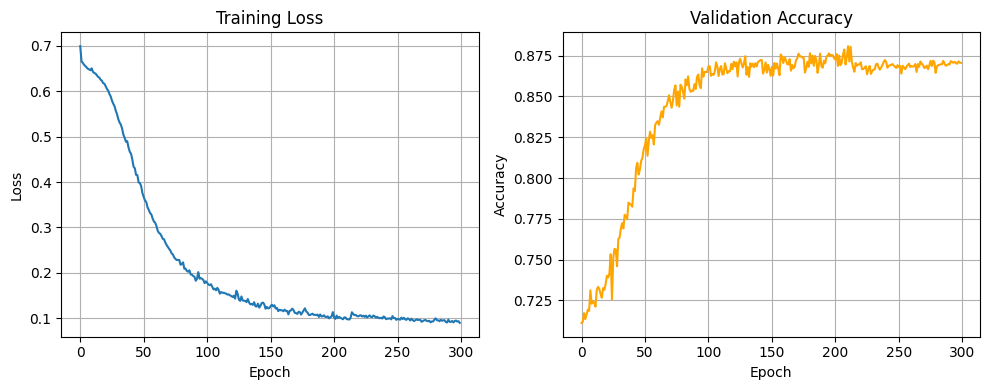


📊 Final Classification Report:
              precision    recall  f1-score   support

     Stage 0       0.82      0.70      0.76       642
     Stage 1       0.82      0.77      0.79      1436
     Stage 2       0.90      0.94      0.92      5115
     Stage 3       0.76      0.69      0.72       459

    accuracy                           0.87      7652
   macro avg       0.82      0.78      0.80      7652
weighted avg       0.87      0.87      0.87      7652



In [24]:
# === Imports ===
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset

# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBED_DIM = 320
NUM_CLASSES = 4
BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 300

# === Load .pt Embedding Data ===
embedding_data = torch.load("data/esm2_embeddings.pt")
delta_X = embedding_data['X']  # shape: [N, 1280]
labels = embedding_data['y']

# === Load Clinical CSV ===
clinical_df = pd.read_csv("data/cancer_data_preprocessed.csv")
clinical_df = clinical_df[["Cancer Type", "Donor Age at Diagnosis", "Donor Sex", "Histology Abbreviation", "Cancer Stage"]].dropna()
clinical_df = clinical_df[clinical_df["Cancer Stage"].isin([1, 2, 3, 4])].reset_index(drop=True)

# === Encode Clinical Features ===
for col in ["Cancer Type", "Donor Sex", "Histology Abbreviation"]:
    clinical_df[col] = LabelEncoder().fit_transform(clinical_df[col])
clinical_df["label"] = clinical_df["Cancer Stage"].astype(int) - 1

# === Dataset Class ===
class CombinedEmbeddingDataset(Dataset):
    def __init__(self, clinical_df, delta_embed_tensor):
        self.age = torch.tensor(clinical_df["Donor Age at Diagnosis"].values, dtype=torch.float32).unsqueeze(-1)
        self.sex = torch.tensor(clinical_df["Donor Sex"].values, dtype=torch.long)
        self.cancer = torch.tensor(clinical_df["Cancer Type"].values, dtype=torch.long)
        self.hist = torch.tensor(clinical_df["Histology Abbreviation"].values, dtype=torch.long)
        self.labels = torch.tensor(clinical_df["label"].values, dtype=torch.long)
        self.delta_embed = delta_embed_tensor.float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.age[idx], self.sex[idx], self.cancer[idx], self.hist[idx],
            self.delta_embed[idx], self.labels[idx]
        )

# === Clinical Embedding ===
class ClinicalEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.age_proj = nn.Linear(1, embed_dim)
        self.sex_embed = nn.Embedding(2, embed_dim)
        self.cancer_embed = nn.Embedding(20, embed_dim)
        self.hist_embed = nn.Embedding(30, embed_dim)

    def forward(self, age, sex, cancer, hist):
        age_emb = self.age_proj(age)
        sex_emb = self.sex_embed(sex)
        cancer_emb = self.cancer_embed(cancer)
        hist_emb = self.hist_embed(hist)
        return torch.stack([age_emb, sex_emb, cancer_emb, hist_emb], dim=1)  # [B, 4, D]

def split_delta_embedding(delta_embed, n_tokens=4):
    return delta_embed.view(delta_embed.size(0), n_tokens, -1)  # [B, 4, 320]

# === Transformer Model ===
class TransformerClassifier(nn.Module):
    def __init__(self, dim, heads=2, ff_dim=64, num_classes=4, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=ff_dim,
                                                   dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)

# === Data Preparation ===
dataset = CombinedEmbeddingDataset(clinical_df, delta_X)
train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.labels.numpy())
train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE)

# === Model Init ===
clinical_embedder = ClinicalEmbedding(EMBED_DIM).to(device)
model = TransformerClassifier(dim=EMBED_DIM, num_classes=NUM_CLASSES).to(device)
optimizer = optim.AdamW(list(model.parameters()) + list(clinical_embedder.parameters()), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# === Training Loop ===
train_losses, val_accuracies = [], []
for epoch in range(1, EPOCHS + 1):
    model.train()
    clinical_embedder.train()
    total_loss = 0
    for age, sex, cancer, hist, delta, label in train_loader:
        age, sex, cancer, hist = age.to(device), sex.to(device), cancer.to(device), hist.to(device)
        delta, label = delta.to(device), label.to(device)

        clinical_token = clinical_embedder(age, sex, cancer, hist)
        delta_token = split_delta_embedding(delta)
        x = torch.cat([clinical_token, delta_token], dim=1)  # [B, 8, 320]

        output = model(x)
        loss = loss_fn(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # === Validation ===
    model.eval()
    clinical_embedder.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for age, sex, cancer, hist, delta, label in val_loader:
            age, sex, cancer, hist = age.to(device), sex.to(device), cancer.to(device), hist.to(device)
            delta, label = delta.to(device), label.to(device)
            clinical_token = clinical_embedder(age, sex, cancer, hist)
            delta_token = split_delta_embedding(delta)
            x = torch.cat([clinical_token, delta_token], dim=1)
            preds = model(x).argmax(dim=1)
            correct += (preds == label).sum().item()
            total += label.size(0)
            y_true.extend(label.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    acc = correct / total
    val_accuracies.append(acc)
    print(f"Epoch {epoch:2d} | Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.4f}")

# === Plot Results ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Acc", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.title("Validation Accuracy")
plt.tight_layout()
plt.show()

# === Final Classification Report ===
print("\n📊 Final Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Stage {i}" for i in range(NUM_CLASSES)]))